# 1. Predicting Gender of Brazilian Names Using Deep Learning


## 1.1 Necessary libraries

In [87]:
import pandas as pd                       
import numpy as np
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, GRU, SimpleRNN, LSTM, Bidirectional, Activation, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


## 1.2 Read the dataset

In [88]:
# Load our data
df = pd.read_excel(r"C:\Users\Jebbar Abdelkader\Desktop\fiabilisation_28_01_2022\Gender Classification With  Machine Learning\training.xlsx")
df.head()

,name,sex
0,Mary,F
1,Anna,F
2,Emma,F
3,Elizabeth,F
4,Minnie,F


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96438 entries, 0 to 96437
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    96438 non-null  object
 1   sex     96438 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


### 1.2.1 Preparing the data 

In [90]:
y = df['sex'].astype("category").cat.codes.values    # y labels into numbers 0 is F and 1 is M
names = df['name'].apply(lambda x: x.lower())             # input names

In [91]:
print("N : " + str(sum(y==2)))
print("M : " + str(sum(y==1)))
print("F : " + str(sum(y==0)))
print(len(y))

N : 117
M : 35097
F : 61224
96438


## 1.3 Encoding Words

Neural networks can only learn to find patterns in numerical data, so it is necessary to convert our data into numeric values with word encoding or tokenization. 

In [92]:
#word encoding
maxlen = 20                                               # max lenght of a name
'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in names]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)
''' The dictionary maps each letter of vocabulary to a number '''
char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

In [93]:
x = prepare_encod_names(names.values)   # Now the names are encod as a vector of numbers 

## 1.4 Split the data into test and train

In [94]:
# train, val, test set will be 60%, 20%, 20% of the dataset respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=40)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

## 1.5 Building the CNN Model

In [11]:
CNNmodel = keras.Sequential()  
CNNmodel.add(Conv1D(32, 2, activation='relu', input_shape=(20,45) )) # 32 convolution filters used each of size 2
CNNmodel.add(Conv1D(64, 3, activation='relu' ))       # 64 convolution filters used each of size 3
CNNmodel.add(MaxPooling1D(pool_size=(1,)))            # choose the best features via pooling
CNNmodel.add(Dropout(0.25))                           # randomly turn neurons on and off to improve convergence
CNNmodel.add(Flatten())                               # flatten we only want a classification output
CNNmodel.add(Dense(150, activation='relu'))           # fully connected to get all relevant data
CNNmodel.add(Dropout(0.1))                            # one more dropout
CNNmodel.add(Dense(1, activation='sigmoid'))          # output 

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adagrad(learning_rate=lr_schedule)
CNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

CNNhistory = CNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val),  epochs=20, batch_size=128) # Getting score metrics
scores = CNNmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
483/483 [==============================] - 3s 5ms/step - loss: 0.6377 - accuracy: 0.6385 - val_loss: 0.6040 - val_accuracy: 0.6541
Epoch 2/20
483/483 [==============================] - 2s 5ms/step - loss: 0.5389 - accuracy: 0.7233 - val_loss: 0.4710 - val_accuracy: 0.7683
Epoch 3/20
483/483 [==============================] - 2s 5ms/step - loss: 0.4476 - accuracy: 0.7894 - val_loss: 0.4168 - val_accuracy: 0.8079
Epoch 4/20
483/483 [==============================] - 3s 5ms/step - loss: 0.4159 - accuracy: 0.8097 - val_loss: 0.3968 - val_accuracy: 0.8204
Epoch 5/20
483/483 [==============================] - 3s 5ms/step - loss: 0.3994 - accuracy: 0.8195 - val_loss: 0.3916 - val_accuracy: 0.8264
Epoch 6/20
483/483 [==============================] - 2s 5ms/step - loss: 0.3902 - accuracy: 0.8238 - val_loss: 0.3794 - val_accuracy: 0.8297
Epoch 7/20
483/483 [==============================] - 3s 5ms/step - loss: 0.3840 - accuracy: 0.8269 - val_loss: 0.3805 - val_accuracy: 0.8257
Epoch 

## 1.6 Building the RNN Model

In [12]:
RNNmodel=keras.Sequential()
RNNmodel.add(SimpleRNN(32, input_shape=(x_train.shape[1],x_train.shape[2]), activation='tanh', return_sequences=True))
RNNmodel.add(TimeDistributed(Dense(1))) 
RNNmodel.add(Flatten())
RNNmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
RNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

RNNhistory=RNNmodel.fit(x_train, y_train , epochs=20, batch_size=128, validation_data=(x_val,y_val))
RNNscores = RNNmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (RNNscores[1]*100))

Epoch 1/20
483/483 [==============================] - 2s 3ms/step - loss: 0.4372 - accuracy: 0.7955 - val_loss: 0.3681 - val_accuracy: 0.8362
Epoch 2/20
483/483 [==============================] - 1s 2ms/step - loss: 0.3644 - accuracy: 0.8356 - val_loss: 0.3719 - val_accuracy: 0.8340
Epoch 3/20
483/483 [==============================] - 1s 2ms/step - loss: 0.3518 - accuracy: 0.8431 - val_loss: 0.3513 - val_accuracy: 0.8425
Epoch 4/20
483/483 [==============================] - 1s 2ms/step - loss: 0.3422 - accuracy: 0.8489 - val_loss: 0.3412 - val_accuracy: 0.8488
Epoch 5/20
483/483 [==============================] - 1s 2ms/step - loss: 0.3323 - accuracy: 0.8516 - val_loss: 0.3332 - val_accuracy: 0.8519
Epoch 6/20
483/483 [==============================] - 1s 2ms/step - loss: 0.3256 - accuracy: 0.8555 - val_loss: 0.3380 - val_accuracy: 0.8493
Epoch 7/20
483/483 [==============================] - 1s 2ms/step - loss: 0.3205 - accuracy: 0.8587 - val_loss: 0.3276 - val_accuracy: 0.8536
Epoch 

## 1.7 Building the GRU Model

In [13]:
GRUmodel=keras.Sequential()
GRUmodel.add(GRU(32, input_shape=(x_train.shape[1],x_train.shape[2]),activation='tanh', return_sequences=True))
GRUmodel.add(TimeDistributed(Dense(1))) 
GRUmodel.add(Flatten())
GRUmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
GRUmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

GRUhistory=GRUmodel.fit(x_train, y_train , epochs=20, batch_size=128, validation_data=(x_val,y_val))
GRUscores = GRUmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (GRUscores[1]*100))  

Epoch 1/20
483/483 [==============================] - 4s 6ms/step - loss: 0.3913 - accuracy: 0.8193 - val_loss: 0.3467 - val_accuracy: 0.8443
Epoch 2/20
483/483 [==============================] - 2s 5ms/step - loss: 0.3270 - accuracy: 0.8538 - val_loss: 0.3207 - val_accuracy: 0.8549
Epoch 3/20
483/483 [==============================] - 2s 5ms/step - loss: 0.2940 - accuracy: 0.8668 - val_loss: 0.3151 - val_accuracy: 0.8582
Epoch 4/20
483/483 [==============================] - 2s 5ms/step - loss: 0.2759 - accuracy: 0.8726 - val_loss: 0.3087 - val_accuracy: 0.8653
Epoch 5/20
483/483 [==============================] - 3s 5ms/step - loss: 0.2578 - accuracy: 0.8750 - val_loss: 0.2900 - val_accuracy: 0.8620
Epoch 6/20
483/483 [==============================] - 2s 5ms/step - loss: 0.2694 - accuracy: 0.8646 - val_loss: 0.2827 - val_accuracy: 0.8632
Epoch 7/20
483/483 [==============================] - 2s 5ms/step - loss: 0.2046 - accuracy: 0.8734 - val_loss: 0.2650 - val_accuracy: 0.8546
Epoch 

## 1.8 Building the DNN Model

In [14]:
DNNmodel = keras.Sequential()                                   # Sequential model
n_inputs = 45                                                   # nº of states  
inputs = keras.Input(shape=(20,n_inputs,), name = 'input')      # Define inputs
l1=layers.Dense(64, activation='relu', name = 'hidden_layer_1')(inputs) 
ly2=layers.Dense(128, activation='softplus', name = 'hidden_layer_2')(l1) 
l3=layers.Dropout(0.25)(ly2)
l4=layers.Flatten()(l3)                 
output=[] 
output.append(layers.Dense(1, activation='sigmoid', name = 'output')(l4))                                    
DNNmodel = keras.Model(inputs=inputs, outputs=output)       

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
DNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

DNNhistory = DNNmodel.fit(x_train, y_train, batch_size=32, epochs=20, validation_data =(x_val, y_val))
DNNscores = DNNmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (DNNscores[1]*100))

Epoch 1/20
1929/1929 [==============================] - 4s 2ms/step - loss: 0.5053 - accuracy: 0.7562 - val_loss: 0.4220 - val_accuracy: 0.7625
Epoch 2/20
1929/1929 [==============================] - 4s 2ms/step - loss: -9.6305 - accuracy: 0.7490 - val_loss: -27.9371 - val_accuracy: 0.7237
Epoch 3/20
1929/1929 [==============================] - 4s 2ms/step - loss: -114.1267 - accuracy: 0.7329 - val_loss: -167.0800 - val_accuracy: 0.7585
Epoch 4/20
1929/1929 [==============================] - 4s 2ms/step - loss: -394.8015 - accuracy: 0.7140 - val_loss: -452.3497 - val_accuracy: 0.6642
Epoch 5/20
1929/1929 [==============================] - 4s 2ms/step - loss: -896.2829 - accuracy: 0.6819 - val_loss: -889.8091 - val_accuracy: 0.6970
Epoch 6/20
1929/1929 [==============================] - 4s 2ms/step - loss: -1596.4427 - accuracy: 0.6781 - val_loss: -1481.4121 - val_accuracy: 0.7127
Epoch 7/20
1929/1929 [==============================] - 4s 2ms/step - loss: -2566.3716 - accuracy: 0.6705 -

## 1.9 Building the BiLSTM Model

In [95]:
LSTMmodel = keras.Sequential()
LSTMmodel.add(Bidirectional(LSTM(64, return_sequences=True), backward_layer=LSTM(64, return_sequences=True, go_backwards=True), input_shape=(maxlen,len_vocab)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Bidirectional(LSTM(64)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(1, activity_regularizer=l2(0.002)))
LSTMmodel.add(Activation('sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
LSTMmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

LSTMhistory = LSTMmodel.fit(x_train, y_train, batch_size=128, epochs=20, validation_data =(x_val, y_val))
LSTMscores = LSTMmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (LSTMscores[1]*100))

Epoch 1/20
483/483 [==============================] - 22s 39ms/step - loss: 0.4185 - accuracy: 0.8118 - val_loss: 0.3658 - val_accuracy: 0.8456
Epoch 2/20
483/483 [==============================] - 18s 37ms/step - loss: 0.3425 - accuracy: 0.8570 - val_loss: 0.3292 - val_accuracy: 0.8608
Epoch 3/20
483/483 [==============================] - 18s 37ms/step - loss: 0.3075 - accuracy: 0.8707 - val_loss: 0.3148 - val_accuracy: 0.8686
Epoch 4/20
483/483 [==============================] - 18s 38ms/step - loss: 0.2734 - accuracy: 0.8780 - val_loss: 0.3391 - val_accuracy: 0.8724
Epoch 5/20
483/483 [==============================] - 18s 38ms/step - loss: 0.2559 - accuracy: 0.8844 - val_loss: 0.2824 - val_accuracy: 0.8822
Epoch 6/20
483/483 [==============================] - 19s 39ms/step - loss: 0.2095 - accuracy: 0.8924 - val_loss: 0.2701 - val_accuracy: 0.8813
Epoch 7/20
483/483 [==============================] - 19s 39ms/step - loss: 0.1811 - accuracy: 0.8977 - val_loss: 0.2665 - val_accuracy:

## 1.10 Figures

<Figure size 432x288 with 0 Axes>

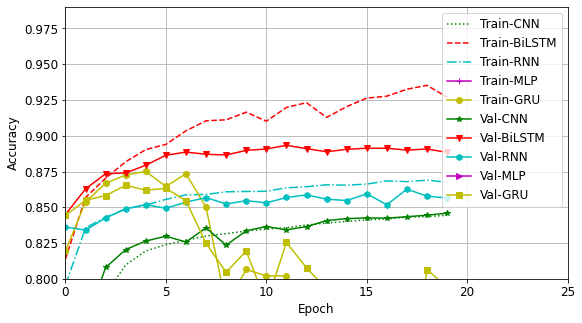

In [16]:
plt.figure(1)
plt.figure(figsize=(9,5))
plt.rcParams.update({'font.size': 12})
# summarize for accuracy
plt.plot(CNNhistory.history['accuracy'], 'g:')
plt.plot(LSTMhistory.history['accuracy'], 'r--')
plt.plot(RNNhistory.history['accuracy'], 'c-.')
plt.plot(DNNhistory.history['accuracy'], 'm-+')
plt.plot(GRUhistory.history['accuracy'], 'y-o')
plt.plot(CNNhistory.history['val_accuracy'], 'g-*')
plt.plot(LSTMhistory.history['val_accuracy'], 'r-v')
plt.plot(RNNhistory.history['val_accuracy'], 'c-h')
plt.plot(DNNhistory.history['val_accuracy'], 'm->')
plt.plot(GRUhistory.history['val_accuracy'], 'y-s')
plt.grid('True')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 0.99)
plt.xlim(0,25)
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')

(0.0, 32.0)

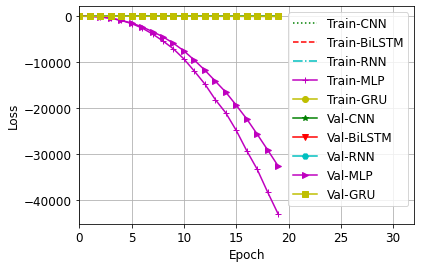

In [17]:
plt.figure(2)
plt.plot(CNNhistory.history['loss'], 'g:')
plt.plot(LSTMhistory.history['loss'], 'r--')
plt.plot(RNNhistory.history['loss'], 'c-.')
plt.plot(DNNhistory.history['loss'], 'm-+')
plt.plot(GRUhistory.history['loss'], 'y-o')
plt.plot(CNNhistory.history['val_loss'], 'g-*')
plt.plot(LSTMhistory.history['val_loss'], 'r-v')
plt.plot(RNNhistory.history['val_loss'], 'c-H')
plt.plot(DNNhistory.history['val_loss'], 'm->')
plt.plot(GRUhistory.history['val_loss'], 'y-s')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-MLP', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-MLP', 'Val-GRU'], loc='upper right')
plt.grid('True')
plt.xlim(0,32)

## 1.11 Statistics

In [20]:
y_predCNN =(CNNmodel.predict(x_test) > 0.5).astype("int32")
y_predLSTM =(LSTMmodel.predict(x_test) > 0.5).astype("int32")
y_predRNN =(RNNmodel.predict(x_test) > 0.5).astype("int32")
y_predGRU =(GRUmodel.predict(x_test) > 0.5).astype("int32")
y_predDNN =(DNNmodel.predict(x_test) > 0.5).astype("int32")

## 1.12 Testing 

In [96]:
testename = prepare_encod_names({"abla"})   # Now the names are encod as a vector of numbers with weight
resu=(LSTMmodel.predict(testename) > 0.5).astype("int32")
if int(resu)==1:
  print('M')
else:
  print('F')

F


In [97]:
def genderpredictor(row):
    
    testename = prepare_encod_names({row})
    resu=(LSTMmodel.predict(testename) > 0.5).astype("int32")
    
    if int(resu)== 0:
        
        return "Female"
    
    elif int(resu)== 1 :
        
        return "Male"
    else:
        
        return "None"


In [98]:
female=pd.read_excel(r"C:\Users\Jebbar Abdelkader\Desktop\ListeFE.xlsx")

In [99]:
female

,name
0,Aafrae
1,Abla
2,Adba
3,Afaf
4,Aicha
...,...
1238,ihiotuiu
1239,xdfrt
1240,uhvg
1241,wxdrxt


In [100]:
for col in female.columns:
        df[col]=df[col].replace('A','a').replace('’','').str.lower().str.strip()
female['name']=female['name'].apply(lambda x:x.replace('’','').lower().strip())

In [101]:
import unidecode

In [102]:
for ind in female['name']:
    female['name']=female['name'].replace(ind,unidecode.unidecode(ind))


In [103]:
female['gender']=female['name'].apply(lambda x:genderpredictor(x))

In [106]:
female[female['gender']=="Female"]

,name,gender
1,abla,Female
2,adba,Female
3,afaf,Female
4,aicha,Female
5,aizza,Female
...,...,...
1229,zouhra,Female
1230,zoulaikha,Female
1232,zouleikha,Female
1233,zoulfa,Female
